## Computing lensing C_ell(ell) for reasonable redshift distribution of sources and parameter values


Eq 1: $C^{ij}_{\mathcal{A}\mathcal{B}}(\ell) = \int d\chi \frac{W^{i}_{\mathcal{A}}(\chi)W^{j}_{\mathcal{B}}(\chi) }{\chi^2}P_{\mathcal{A}\mathcal{B}} ( k = \frac{\ell + 0.5}{\chi}, z) $

Where:
- i,j denote redshift bins
- Subscripts $\mathcal{A}\mathcal{B} \in \{\delta_g, \kappa\}$ stand for specific E- and B- modes (kappa) or for specific observed galaxy number densities (delta)
- C is the angular power spectrum
- $P_{\delta}$ is three-dimensional matter power spectrum
- $\chi$ is comoving distance

Eq 4: $W^{i}_{\kappa,g}(\chi) = \frac{3\Omega_{m}H_{0}^{2}}{2c^2} \int_{\chi}^{\infty}d\chi'n^{i}_{g}(\chi')\frac{\chi}{a(\chi)}\frac{\chi' - \chi}{\chi'}$

Where W is the tomographic lens efficiency

We are looking for shear power spectra, so:

$C^{ij}_{EE}(\ell) = C^{ij}_{\kappa_s\kappa_s}(\ell) + C^{ij}_{\kappa_s I_E}(\ell) + C^{ji}_{\kappa_s I_E}(\ell) + C^{ij}_{I_E I_E}(\ell)$

or 

$C^{ij}_{BB}(\ell) = C^{ij}_{I_B I_B}(\ell)$

$I_{E/B}$ stand for the E/B mode decomposition of IA, and we will ignore these components for our analysis.
$\kappa_s$ stands for the tomographic convergence field of the source galaxy (?)

In [1]:
""" defining all functions to find C_ell """

# define the reasonable redshift distribution from github
def redshiftdist(z):
    
    i_lim = 26.                                                            # Limiting i-band magnitude
    z0 = 0.0417 * i_lim - 0.744
    pz = 1. / (2. * z0) * (z / z0)**2. * np.exp(-z / z0)                   # Redshift distribution, p(z)
    
    return pz                                                              # to check for normalized pz print(scipy.integrate.simps(pz, z))

# solves equation 4
# note: z here is an array not a single value. returns array

def Wkappag(z, c, cosmo):
    
    zmax = 6.                                                              # z at horizon from Planck 2018
    a = 1/(1 + z)
    chiz = ccl.comoving_radial_distance(cosmo,a)                           # units of Mpc
    
    Wkg = np.zeros(len(z))     
    for i in range(len(z)):                                                # TODO is this a reasonable way of calculating this stuff?
        x = np.linspace(z[i],zmax,int(1e4))                                # variable we integrate over
        ax = 1/(1 + x)
        chix = ccl.comoving_radial_distance(cosmo,ax)
        dchidx = c/(cosmo['H0']*ccl.h_over_h0(cosmo,ax))
        px = redshiftdist(x)
        integrand = px*chiz[i]*(chix - chiz[i])/(a[i]*chix)
        Wkg[i] = scipy.integrate.simps(integrand, x)*3*cosmo['Omega_m']*(cosmo['H0']**2)/(2*c**2)
    Wkg[len(z)-1] = 0.0                                                    # The last integral is over nothing. to avoid nan
    
    return Wkg

# function that finds C_ell(ell) for a given z distribution. A, B, i, j can be changed by manually changing quantities in the function
# Note: if we assume \LambdaCDM cosmology (or some cosmology) don't need function h_over_h0. 
# Can find chi(z) and z(chi) manually

def findC_ell(cosmo,c,ell,z):
                                                                          # find useful functs of z
    a = 1/(1 + z)
    chiz = ccl.comoving_radial_distance(cosmo,a)
    Wkg = Wkappag(z, c, cosmo)                                            # find tomographic lens efficiency
                                                                          # find matter power spectrum
    MatterPowerSpec_lz = np.zeros((len(z),len(ell)))
    for i in range(len(z)):                                               # MatterPowerSpec_lz[i] is for ith z
        MatterPowerSpec_lz[i] = ccl.power.nonlin_power(cosmo, (ell + 0.5)/chiz[i] , a[i])
    MatterPowerSpec_lz = np.transpose(MatterPowerSpec_lz)
                                                                          # find C_ell
    C_ell = np.zeros(len(ell))
    for i in range(len(ell)):
        integrand = (Wkg**2)*MatterPowerSpec_lz[i]/(chiz**2)
        C_ell[i] = scipy.integrate.simps(integrand, chiz, axis = 0)
    return C_ell

def findC_ell_linear(cosmo,c,ell,z):
                                                                          # find useful functs of z
    a = 1/(1 + z)
    chiz = ccl.comoving_radial_distance(cosmo,a)
    Wkg = Wkappag(z, c, cosmo)                                            # find tomographic lens efficiency
                                                                          # find matter power spectrum
    MatterPowerSpec_lz = np.zeros((len(z),len(ell)))
    for i in range(len(z)):                                               # MatterPowerSpec_lz[i] is for ith z
        MatterPowerSpec_lz[i] = ccl.power.linear_power(cosmo, (ell + 0.5)/chiz[i] , a[i])
    MatterPowerSpec_lz = np.transpose(MatterPowerSpec_lz)
                                                                          # find C_ell
    C_ell = np.zeros(len(ell))
    for i in range(len(ell)):
        integrand = (Wkg**2)*MatterPowerSpec_lz[i]/(chiz**2)
        C_ell[i] = scipy.integrate.simps(integrand, chiz, axis = 0)
    return C_ell

In [2]:
#bits of the code come from CCLX/Example MCMC analysis on GitHub

import matplotlib.pyplot as plt 
import pyccl as ccl
import numpy as np
import scipy
%matplotlib inline

# for nicer plots http://seaborn.pydata.org -- optional
# if you don't want to use it, you can comment this and the next line

import seaborn as sns; sns.set_style('darkgrid')
sns.set_context("talk")

# Program starts here

In [11]:
""" define cosmological parameters """
cosmo = np.zeros((3,3) , dtype=object)

for i in range(len(cosmo)):
    for j in range(len(cosmo[0])):
        cosmo[i][j] = ccl.Cosmology(Omega_c = 0.23, # + (0.04 * i), 
                      Omega_b = 0.045, 
                      h = 0.67, 
                      n_s = 0.7 + (0.15 * i),
                      sigma8 = 0.7 + 0.25 * j, 
                      transfer_function='bbks')
cosmo = np.append(np.append(cosmo[0] , cosmo[1]) , cosmo[2])

c = 3e5                                                                  # km/s

In [12]:
""" define cosmological parameters for equivalent linear theory """

cosmo1 = np.zeros((3,3) , dtype=object)

for i in range(len(cosmo1)):
    for j in range(len(cosmo1[0])):
        cosmo1[i][j] = ccl.Cosmology(Omega_c = 0.23, # + (0.04 * i), 
                      Omega_b = 0.045, 
                      h = 0.67, 
                      n_s = 0.7 + (0.15 * i),
                      sigma8 = 0.7 + 0.25 * j, 
                      transfer_function='bbks',
                      matter_power_spectrum='linear')
cosmo1 = np.append(np.append(cosmo1[0] , cosmo1[1]) , cosmo1[2])


In [ ]:
""" Finding C_ell_array (our training data) - defining function """

def findC_ell_array(ell_min, ell_max, ell_bin_num, cosmo, z, Binned_distribution):
    
    #find ell arrays and empty arrays
    
    ell = np.arange(ell_min, ell_max)
    C_ell = np.zeros((len(cosmo),len(Binned_distribution), len(Binned_distribution), len(ell)))
    
    # define quantities for binning C_ell
    
    C_ell_array = []
    
    ell_binned_limits = np.logspace(np.log10(ell_min),np.log10(ell_max),num=ell_bin_num + 1)
    bin_edge1 = ell_binned_limits[:-1]
    bin_edge2 = ell_binned_limits[1:]
    ell_binned = (bin_edge1 + bin_edge2) / 2
    
    longell = []
    for i in range(int(len(cosmo)*((len(Binned_distribution) + 1) * len(Binned_distribution) / 2))):
        longell = np.append(longell, ell_binned)

    # find C_ell for a range of ells, then bin these to find C_ell_array 

    #Note: this gives list of C_ell[i][j][k][ell]: ith cosmology, cross correlated over jth and kth binned redshift 
    #      distribution for each binned value of ell. 

    for i in range(len(cosmo)):
        for j in range(len(Binned_distribution)):
            for k in range(len(Binned_distribution)):
                if k > j:
                    break
                tracer1 = ccl.WeakLensingTracer(cosmo[i], dndz=(z, Binned_distribution[j])) # TODO normalization
                tracer2 = ccl.WeakLensingTracer(cosmo[i], dndz=(z, Binned_distribution[k]))
                C_ell[i][j][k] = ccl.angular_cl(cosmo[i], tracer1, tracer2, ell)            # uses non-linear matter power spectrum stored in `cosmo`
            
                # bin ell
                bin_means, bin_edges, binnumber = scipy.stats.binned_statistic(ell, C_ell[i][j][k], statistic='mean', 
                                                                               bins= ell_binned_limits)
    
                C_ell_array = np.append(C_ell_array, bin_means)
    return longell, C_ell_array

In [ ]:
# define ell and C_ell shapes 

ell_min = 2
ell_max = 2060

# define quantities for binning of ell

ell_bin_num = 18

C_ell_data = findC_ell_array(ell_min, ell_max, ell_bin_num, cosmo, z, Binned_distribution)


In [6]:
# create an angular shear C_ell manually with our functions above
# Note: define ell from github 
# np.seterr(divide='ignore', invalid='ignore') -- in integrals ignores bits when/0

ell = np.arange(2, 2000)
delta_ell = ell[1] - ell[0]
z = np.linspace(0.001, 4., int(1e4))                                     # z =/= 0 otherwise get inf when calculating chi

print(scipy.integrate.simps(redshiftdist(z), z))                         # To check whether p(z) is normalized

# calculate C_ell
manualdata = findC_ell(cosmo,c,ell,z)

0.9993590255745917


In [7]:
# calculate C_ell_linear

manualdata_linear = findC_ell_linear(cosmo1,c,ell,z)

In [8]:
#create an angular shear C_ell with pyccl from github (non-linear and linear)

i_lim = 26.                                                              # Limiting i-band magnitude
z0 = 0.0417 * i_lim - 0.744
Ngal = 46. * 100.31 * (i_lim - 25.)                                      # Normalisation, galaxies/arcmin^2
pz = 1. / (2. * z0) * (z / z0)**2. * np.exp(-z / z0)                     # Redshift distribution, p(z)
dNdz = Ngal * pz                                                         # Number density distribution
#why are they normalizing with Ngal? Tracer renormalizes to 1 anyways

tracer1 = ccl.WeakLensingTracer(cosmo, dndz=(z, dNdz))
tracer2 = ccl.WeakLensingTracer(cosmo, dndz=(z, dNdz))
data    = ccl.angular_cl(cosmo, tracer1, tracer2, ell)                   # C_ell - uses non-linear matter power spectrum stored in `cosmo`

data_linear = ccl.angular_cl(cosmo1, tracer1, tracer2, ell)

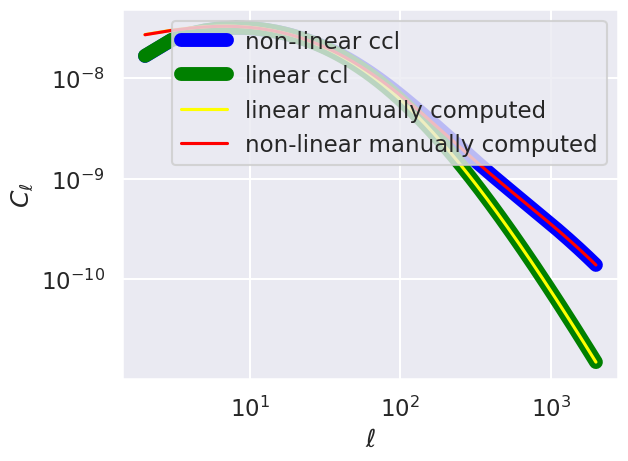

In [9]:
# Plots of C_ell

plt.plot(ell, data, "b", linewidth=10, label = "non-linear ccl")

plt.plot(ell, data_linear, "g", linewidth=10, label = "linear ccl")

plt.plot(ell, manualdata_linear, "yellow", label = "linear manually computed")

plt.plot(ell,manualdata, "r", label = "non-linear manually computed")

#plt.plot(ell, data/manualdata)

plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\ell$')
plt.ylabel(r'$C_\ell$')
plt.legend()
plt.show()

#Note: low ell values differ because I'm using liber approximation (only works for high ell?)

In [10]:
print("chi_max = ", ccl.comoving_radial_distance(cosmo,1/(1+1090.3)))

chi_max =  13946.40834035793
